# Theft Detection using meter data for Microgrid in Haiti

Our project involves working with 15 minute resolution consumption data for a microgrid in Haiti. This microgrid is owned & operated by EarthSpark International[1] (an NGO based out of DC) and the metering infrastructure is provided by SparkMeter[2] who provides the base AMI as well as cloud services like data storage, meter control, automatic billing and grid performance analysis.

**Collaborators:** 

For this project we are collaborating with *SparkMeter*, a meter manufacturing company based out of Washington DC, who are providing us with the aforementioned consumption data as well as some insights into the mechanisms by which electricity theft occurs in developing regions like Haiti.

**Representatives from SparkMeter:**
1. Arthur Jacquiau Chamski (VP of Products)
2. Dan Schnitzer (CEO)

**Problem in brief:**

The microgrid in Haiti experiences theft owing to the low income demographic in the region. We aim to analyse the data in order to detect theft or non-technical loss and pin point on the theft offenders. 

We have utilized two different approches to detect theft or non technical loss:

1. Using correlation analysis
2. Using clustering methods

We've given below a step by step walkthrough of the process we used in the two approaches and what conclusions we could draw from the same. 

##  Initial setup

In few cells below we load the required modules, load the file with the data that encapsulates the the technical and non technical loss for each timestamp along with some other information about the state of the microgrid in that timestamp. 

### Loading required modules

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import Counter
%matplotlib inline

### Common data load

In [2]:
losses = pd.read_csv("LA_losses.csv", parse_dates =['heartbeat_end'])
losses_bc = losses[losses.subnet =='BC']
losses_bc = losses_bc.assign(day = losses_bc['heartbeat_end'].dt.date)
losses_bc.head(5)

,heartbeat_end,day,subnet,num_cust,kwh_cust,w_avg_cust,cost,num_cust_off,num_tot,kwh_tot,w_avg_tot,kWh_self_active,kWh_self_inactive,kwh_TL,kwh_NTL,month,period,tod
0,2016-02-05 00:00:00,2016-02-05,BC,101.0,0.233750,830.0,13.122656,14.0,2,0.374750,1496,0.06525,0.0056,0.082537,0.058462,2,-35,night_0_7
1,2016-02-05 00:15:00,2016-02-05,BC,101.0,0.230719,822.0,13.310156,14.0,2,0.372375,1484,0.06525,0.0056,0.082386,0.059270,2,-35,night_0_7
2,2016-02-05 00:30:00,2016-02-05,BC,101.0,0.233687,832.0,13.352813,15.0,2,0.373969,1492,0.06450,0.0060,0.082184,0.058097,2,-35,night_0_7
3,2016-02-05 00:45:00,2016-02-05,BC,101.0,0.231687,820.0,13.248750,15.0,2,0.396719,1582,0.06450,0.0060,0.082084,0.082947,2,-35,night_0_7
4,2016-02-05 01:00:00,2016-02-05,BC,101.0,0.245031,882.0,13.976719,15.0,2,0.422438,1684,0.06450,0.0060,0.082752,0.094655,2,-35,night_0_7


Important to note here that 4 time of day categories have been defined:

1. night : 12AM (Midnight) to 7AM
2. daytime: 7AM to 12PM (Noon)
3. afternoon: 12PM (Noon) to 5PM
4. evening: 5PM to 12AM (Midnight)

### Plotter function

Defined below is a helper function to plot the load profile and correaltion matrix of the main indicators and the suspect meters for a certain period. This plotter function is common to both the approaches described below.

In [3]:
def plot_period(df,book,day,pd=None,MM=['kwh_tot','kwh_cust','kwh_NTL'],meters=None):
    
    pds = ['night_0_7','daytime_7_12','afternoon_12_17','evening_17_0'];
    
    if pd is None:
        if meters is None:
            meters = [i[0] for i in book[day].most_common(11)[1:]]
        idx = df.index[df['day']==dt.datetime.strptime(day, '%Y-%m-%d')]
    else:
        if meters is None:
            try:
                meters = [i[0] for i in book[day+' '+pds[pd]].most_common(12)[1:]]
            except KeyError:
                print 'There was no significant non-technical losses reported on '+day+' '+pds[pd]
                return
        
        idx = df.index[(df['day']==dt.datetime.strptime(day,'%Y-%m-%d')) & (df['tod']==pds[pd])]
    
    ax = plt.gca()
    ax2 = ax.twinx()
    ax.set_prop_cycle('color', ['black', (0.8862745098, 0.2901960784, 0.2),(0.572549019, 0.776470588, 1.0)])
    X = df.loc[idx,MM].values; X = (X - np.mean(X,axis=0))/(np.std(X,axis=0)+1e-4)
    ax.plot(df.loc[idx,'heartbeat_end'].dt.time,X,linewidth=3);
    X = df.loc[idx,meters].values; X = (X - np.mean(X,axis=0))/(np.std(X,axis=0)+1e-4)
    ax2.plot(df.loc[idx,'heartbeat_end'].dt.time,X);  

    labels = ax.get_xticklabels(); plt.setp(labels,rotation='vertical')
    ax.grid(True); ax.set_title(day+' '+pds[pd])
    ax.legend(MM, loc='center left', bbox_to_anchor=(1.2, 1))
    ax2.legend(meters, loc='center left', bbox_to_anchor=(1.2, 0.3))
    temp = df.loc[idx,MM+meters].copy()
    print 'Correlation matrix:'
    print temp.corr(method='pearson').iloc[3:,:3]
    
    pass

## Approach 1: Using Correlation Analysis

### Loading the data
The Detailed consumption file provides the consumption per customer at the end of a given heartbeat for each subnet. Our first task is to load the two files for detailed consumption and for the losses. We will only foucs on the BC subnet within the dataset. In this segment we noticed that both files have data from the same region but one of the files has a time offset. We take care of this by utilizing the parse dates method while reading the file which will include the time zone information.

In [4]:
detailed_consumption = pd.read_csv("LA_detailed_consumption.csv", parse_dates =['heartbeat_end'])
detailed_bc = detailed_consumption[detailed_consumption.subnet == 'BC']
detailed_bc.reset_index(inplace = True, drop = True)
detailed_bc.head(5)

,serial,heartbeat_end,subnet,kilowatt_hours,true_power_avg
0,SM15R-01-0000028A,2016-04-27 19:30:00,BC,0.000156,0
1,SM15R-01-00000290,2016-04-27 19:30:00,BC,0.000000,0
2,SM15R-01-00000273,2016-04-27 19:30:00,BC,0.000281,0
3,SM15R-01-0000026C,2016-04-27 19:30:00,BC,0.000812,2
4,SM15R-01-00000184,2016-04-27 19:30:00,BC,0.000937,2


Below, we merge the two loaded files based on the timestamp

In [5]:
bc_consumption = pd.merge(detailed_bc, losses_bc, how='inner', on = 'heartbeat_end')
bc_consumption = bc_consumption[bc_consumption.kilowatt_hours>0]
print ("dataset size: " + str(len(bc_consumption)))
bc_consumption.head(5)

dataset size: 737576


,serial,heartbeat_end,subnet_x,kilowatt_hours,true_power_avg,day,subnet_y,num_cust,kwh_cust,w_avg_cust,...,num_tot,kwh_tot,w_avg_tot,kWh_self_active,kWh_self_inactive,kwh_TL,kwh_NTL,month,period,tod
0,SM15R-01-0000028A,2016-04-27 19:30:00,BC,0.000156,0,2016-04-27,BC,102.0,0.145125,524.0,...,2,0.292656,1168,0.06225,0.0076,0.077106,0.070425,4,-23,afternoon_12_17
2,SM15R-01-00000273,2016-04-27 19:30:00,BC,0.000281,0,2016-04-27,BC,102.0,0.145125,524.0,...,2,0.292656,1168,0.06225,0.0076,0.077106,0.070425,4,-23,afternoon_12_17
3,SM15R-01-0000026C,2016-04-27 19:30:00,BC,0.000812,2,2016-04-27,BC,102.0,0.145125,524.0,...,2,0.292656,1168,0.06225,0.0076,0.077106,0.070425,4,-23,afternoon_12_17
4,SM15R-01-00000184,2016-04-27 19:30:00,BC,0.000937,2,2016-04-27,BC,102.0,0.145125,524.0,...,2,0.292656,1168,0.06225,0.0076,0.077106,0.070425,4,-23,afternoon_12_17
7,SM15R-01-00000200,2016-04-27 19:30:00,BC,0.000344,0,2016-04-27,BC,102.0,0.145125,524.0,...,2,0.292656,1168,0.06225,0.0076,0.077106,0.070425,4,-23,afternoon_12_17


We would now like to analyze the consumption patterns of each user at a given time of day. We spit the dataset to time of day so we are able to better identify 
<ol>
<li>
Who are likely contenters of causing theft </li>
<li>When does theft occur most</li>
</ol>

In [6]:
bc_consumption.dropna(axis = 0, inplace = True)
bc_consumption = bc_consumption[bc_consumption.heartbeat_end >= '2016-08-15']
bc_consumption = bc_consumption[bc_consumption.heartbeat_end <= '2016-09-30']

grouped_bc = bc_consumption.groupby(['day', 'serial','tod'])

We compute the pearson correlation scores for each group i.e. the individual consumption vs the NTL loss. The idea is to find customers with frequent high negative correlations i.e. 

<ul>
<li>When the NTL loss increases the customers usage decreases, implying they may be stealing at this time.</li>
<li>When the NTL loss decreases the customers usage increases, implying the loss marginally decreases because they stopped stealing.</li>
</ul>

We make sure that we have at least 10 data points so we the method is able to compute a meaningful correlation. We only consider those cases where the p value is less that 0.05. 

In [7]:
dates = []
user = []
score =[]
tod =[]
for name ,group in grouped_bc:
    corr =  stats.spearmanr(group['kwh_NTL'], group['kilowatt_hours'])
    if corr[1] <= 0.05 and len(group)>10:
        dates.append(name[0])
        user.append(name[1])
        score.append(corr[0])
        tod.append(name[2])

This gives us the below set of data points

In [8]:
corr_df = pd.DataFrame(columns = ['user','date','score','tod'])
corr_df['user'] = user
corr_df['date'] = dates
corr_df['score'] = score
corr_df['tod'] = tod

We now have the consumption patters we only consider the negative correlations. We then find the customers who have high repeated cases of negative correlations.

In [9]:
corr_df = corr_df.sort_values(by= ['date','score'], ascending = [True,True])
corr_n = corr_df[corr_df.score<0]
corr_n.user.value_counts().head(15)

SM15R-01-000001F6    53
SM15R-01-00000263    41
SM15R-01-0000028A    38
SM15R-01-00000260    38
SM15R-01-00000219    35
SM15R-01-00000191    33
SM15R-01-000001A9    33
SM15R-01-0000031D    33
SM15R-01-0000010C    33
SM15R-01-00000127    32
SM15R-01-000000ED    32
SM15R-01-0000020C    29
SM15R-01-000001B1    28
SM15R-01-000001A8    28
SM15R-01-000000C8    27
Name: user, dtype: int64

In the cell below, we segragate the correlation data based on time of day and find top 10 offender in each of the time of day categories as described above in the notebook

In [10]:
top_th = corr_n.user.value_counts()
top5 = []

for i in range(5):
    top5.append(top_th.index[i])

temp = corr_n.groupby(['tod'])    
print "Count" , "tod"
for name, grp in temp:
    print len(grp) ," ", name

for name, group in temp:
    corr_night = corr_n[corr_n.tod == name]
    corr_night = corr_night[corr_night.score< -0.50]
    print "\nTop 10 Offenders at ",name, " time:"
    print corr_night.user.value_counts()[:10]

Count tod
50   afternoon_12_17
353   daytime_7_12
22   evening_17_0
894   night_0_7

Top 10 Offenders at  afternoon_12_17  time:
SM15R-01-000001CE    2
SM15R-01-00000243    2
SM15R-01-0000031D    2
SM15R-01-000000C8    2
SM15R-01-000001A6    2
SM15R-01-0000020F    2
SM15R-01-000001B1    2
SM15R-01-0000012D    2
SM15R-01-0000011F    1
SM15R-01-0000011D    1
Name: user, dtype: int64

Top 10 Offenders at  daytime_7_12  time:
SM15R-01-000001F6    20
SM15R-01-000001A9    16
SM15R-01-00000263    12
SM15R-01-0000031D    11
SM15R-01-0000020C    10
SM15R-01-00000191     9
SM15R-01-0000010C     9
SM15R-01-00000260     9
SM15R-01-00000219     8
SM15R-01-00000127     8
Name: user, dtype: int64

Top 10 Offenders at  evening_17_0  time:
SM15R-01-000000C8    2
SM15R-01-000001A9    2
SM15R-01-0000013D    1
SM15R-01-000001AD    1
SM15R-01-0000026C    1
SM15R-01-0000021C    1
SM15R-01-000001D9    1
SM15R-01-000000C2    1
SM15R-01-000001A6    1
SM15R-01-0000028A    1
Name: user, dtype: int64

Top 10 Offe

Below we evaluate the users who steal only during one time of day

In [11]:
detailed_bc = detailed_bc.loc[detailed_bc.subnet == 'BC',:]; detailed_bc.reset_index(inplace = True, drop = True)
detailed_bc.drop(['subnet','true_power_avg'],axis = 1, inplace = True)
detailed_bc = detailed_bc.pivot(index='heartbeat_end',columns='serial',values='kilowatt_hours')
detailed_bc.reset_index(inplace = True);# detailed_bc.set_index(['heartbeat_end'],inplace = True);
detailed_bc.head()

bc_consumption = pd.merge(losses_bc, detailed_bc, how='inner')
bc_consumption.drop(['subnet','cost','kWh_self_inactive', 'num_cust','num_cust_off',
                      'kWh_self_active','w_avg_tot','num_tot','month','w_avg_cust','period'],axis = 1, inplace = True)
bc_consumption.sort_values('heartbeat_end', inplace=True)
bc_consumption.head()

,heartbeat_end,day,kwh_cust,kwh_tot,kwh_TL,kwh_NTL,tod,SM15R-01-0000004D,SM15R-01-00000054,SM15R-01-0000008A,...,SM20R-02-00000DB6,SM20R-02-00000DB8,SM20R-02-00000DB9,SM20R-02-00000DBA,SM20R-02-00000DBB,SM20R-02-00000DBE,SM20R-02-00000DBF,SM20R-02-00000DC6,SM20R-02-00000DC7,SM20R-02-00000DCE
0,2016-02-05 00:00:00,2016-02-05,0.233750,0.374750,0.082537,0.058462,night_0_7,0.0,0.0,0.002812,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-02-05 00:15:00,2016-02-05,0.230719,0.372375,0.082386,0.059270,night_0_7,0.0,0.0,0.002781,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-02-05 00:30:00,2016-02-05,0.233687,0.373969,0.082184,0.058097,night_0_7,0.0,0.0,0.002969,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-02-05 00:45:00,2016-02-05,0.231687,0.396719,0.082084,0.082947,night_0_7,0.0,0.0,0.002844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-02-05 01:00:00,2016-02-05,0.245031,0.422438,0.082752,0.094655,night_0_7,0.0,0.0,0.002844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Based on the list we got above, in order to visualize the theft we choose some offenders from one of the time of day categories. The meters variable below has 5 candidates from the 'night' category.

In [12]:
meters =['SM15R-01-000000ED','SM15R-01-0000028A','SM15R-01-000001F6','SM15R-01-00000219','SM15R-01-00000260']

Let us plot the non technical loss, consumption of meters for a particular day to visualize the result

Correlation matrix:
                    kwh_tot  kwh_cust   kwh_NTL
SM15R-01-000000ED  0.492115  0.438251  0.098986
SM15R-01-0000028A  0.870275  0.858391 -0.316778
SM15R-01-000001F6  0.415482  0.338975  0.458243
SM15R-01-00000219  0.873980  0.899702 -0.302711
SM15R-01-00000260  0.807202  0.825869 -0.258009


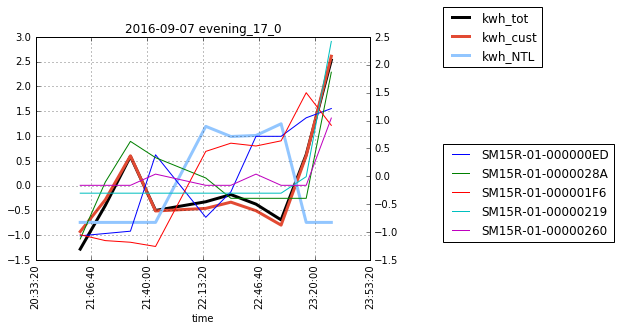

In [13]:
bc_consumption.day = pd.to_datetime(bc_consumption.day,infer_datetime_format=True)
plot_period(bc_consumption,None,day='2016-09-07',pd=3, meters = meters)

## Approach 2: Using K-Means Clustering

The primary challenge of this problems statement is that we lack ground truth information about the identity of the real offenders. SparkMeter has some reporting on the ground in Haiti based on which they have given us confirmation of four offending homes during the period August and September 2016. Therefore an unsupervised approach would be useful to identify suspects.

Given that `kwh_cust` corresponds to the sum of readings across all meters in a zone, the load profile of each meter relative to the load profile of `kwh_cust` over a certain period might provide useful information to identify suspects. During a period when theft occurs (e.g. evenings 19:00-23:00), the similar the load profile of a meter is to the load shape of the totalizer, the higher the chances that the home corresponding to that meter is contributing to the total non technical loss.

To develop this approach, we are analyzing the data of total consumption and consumption per meter on a daily basis, and creating k clusters for each period of the day (i.e. morning, daytime, evening and night) using K-means++. A matrix is set up where the columns refer to the time of the day, and the rows to all meters including the totalizer. The matrix is normalized by rows in order to capture variance of the load throughout the chosen period for each meter.

### Data load and preparation

We load the consumption file with the 15 minute resolution data and extract only data of meters in one of the sub networks (called BC) which consists of greater than 100 meters.

In [18]:
detailed_bc = pd.read_csv("LA_detailed_consumption.csv",parse_dates=['heartbeat_end'])
detailed_bc = detailed_bc.loc[detailed_bc.subnet == 'BC',:]; detailed_bc.reset_index(inplace = True, drop = True)
detailed_bc.drop(['subnet','true_power_avg'],axis = 1, inplace = True)
detailed_bc = detailed_bc.pivot(index='heartbeat_end',columns='serial',values='kilowatt_hours')
detailed_bc.reset_index(inplace = True);# detailed_bc.set_index(['heartbeat_end'],inplace = True);
detailed_bc.head()

serial,heartbeat_end,SM15R-01-0000004D,SM15R-01-00000054,SM15R-01-0000008A,SM15R-01-0000008D,SM15R-01-0000008E,SM15R-01-00000091,SM15R-01-0000009E,SM15R-01-000000B5,SM15R-01-000000B6,...,SM20R-02-00000DB6,SM20R-02-00000DB8,SM20R-02-00000DB9,SM20R-02-00000DBA,SM20R-02-00000DBB,SM20R-02-00000DBE,SM20R-02-00000DBF,SM20R-02-00000DC6,SM20R-02-00000DC7,SM20R-02-00000DCE
0,2016-02-01 00:00:00,0.0,0.0,0.002594,0.0,0.0,0.0,0.000000,0.0,0.000562,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-02-01 00:15:00,0.0,0.0,0.000313,0.0,0.0,0.0,0.000000,0.0,0.002844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-02-01 00:30:00,0.0,0.0,0.000000,0.0,0.0,0.0,0.000937,0.0,0.002844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-02-01 00:45:00,0.0,0.0,0.000000,0.0,0.0,0.0,0.000219,0.0,0.000937,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-02-01 01:00:00,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000313,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We merge the primary loss file (created in the initial setup) and consumption file created above and sort the values based on the heartbeat_end column which is basically represents the timestamp for which the data was collected.

In [155]:
bc_consumption = pd.merge(losses_bc, detailed_bc, how='inner')
bc_consumption.drop(['subnet','cost','kWh_self_inactive', 'num_cust','num_cust_off',
                      'kWh_self_active','w_avg_tot','num_tot','month','w_avg_cust','period'],axis = 1, inplace = True)
bc_consumption.sort_values('heartbeat_end', inplace=True)
bc_consumption.head()

,heartbeat_end,day,kwh_cust,kwh_tot,kwh_TL,kwh_NTL,tod,SM15R-01-0000004D,SM15R-01-00000054,SM15R-01-0000008A,...,SM20R-02-00000DB6,SM20R-02-00000DB8,SM20R-02-00000DB9,SM20R-02-00000DBA,SM20R-02-00000DBB,SM20R-02-00000DBE,SM20R-02-00000DBF,SM20R-02-00000DC6,SM20R-02-00000DC7,SM20R-02-00000DCE
0,2016-02-05 00:00:00,2016-02-05,0.233750,0.374750,0.082537,0.058462,night_0_7,0.0,0.0,0.002812,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-02-05 00:15:00,2016-02-05,0.230719,0.372375,0.082386,0.059270,night_0_7,0.0,0.0,0.002781,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-02-05 00:30:00,2016-02-05,0.233687,0.373969,0.082184,0.058097,night_0_7,0.0,0.0,0.002969,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-02-05 00:45:00,2016-02-05,0.231687,0.396719,0.082084,0.082947,night_0_7,0.0,0.0,0.002844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-02-05 01:00:00,2016-02-05,0.245031,0.422438,0.082752,0.094655,night_0_7,0.0,0.0,0.002844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Programming the K-means++ algorithm

In lieu of starting the K-means++ algorithm picking a random row as a center, we fixed the raw corresponding to `kwh_cust` as the initial center. In this way, all meters will start in same cluster with the totalizer. As the K-means++ algorithm runs, the meters with load shapes different from the totalizer's will migrate to other clusters, so at the end, the totalizer will only share its cluster with the meters that render a similar profile. To implement this we define the two fucntions below.

In [149]:
def init_centers(X, k, dataset):
    mu = np.zeros((k,X.shape[1]))
    #cl = [np.random.choice(X.shape[0],1)]
    op = np.arange(1,X.shape[0])
    cl = [0]
    mu[0] = X[0,:]
    

    for i in xrange(len(cl),k):
        Y = mu[:i,:]
        dist = np.min((-2*X.dot(Y.T) + np.sum(X**2,axis=1)[:,None] + np.sum(Y**2, axis=1)),axis=1)
        dist[dist<0] = 0.0
        pr = dist/np.sum(dist)
#         temp = np.argmax(pr)
        temp = np.random.choice(np.arange(X.shape[0])[op],1,p=pr[op]/np.sum(pr[op]))
        op = np.delete(op,np.where(op)==temp,0)
        cl.append(temp.tolist())
        mu[i] = X[temp,:]

    return mu

def KMeans(X, centers, niters=20):
    d_dist = [[99999,99999]]
    for _ in range(niters):
        # Assign a cluster to every row of X
        dist = (-2*X.dot(centers.T) + np.nansum(X**2,axis=1)[:,None] + np.nansum(centers**2, axis=1))
        d_dist.append([np.nanmean(np.nanmin(dist,axis=1)),np.nanmax(np.nanmin(dist,axis=1))])
        if np.abs(d_dist[-2][0]-d_dist[-1][0]) < 1e-2:
            break
        Cl = np.eye(centers.shape[0])[np.nanargmin(dist,axis=1),:]
        # Compute the means
        centers = Cl.T.dot(X)/np.nansum(Cl,axis=0)[:,None]

    closest = np.argmin(dist,axis=0)
    return centers,Cl,closest,np.array(d_dist)

### Identify suspects in defined period 

Below we have defined a function to identify suspects in a defined period.

The following cleaning process to the data was undertaken before running K-means++:

- Only meters that have more than 60% of valid data (i.e. no NaN values) are considered in each period.
- Given the diversity of observed load profiles, the number of clusters the be created varies per period and corresponds to 20% of the available samples.
- For each period, the data matrix was normalized along rows (i.e. per meter) by subtracting the mean and dividing into standard deviation.
- The following script focuses on identifying suspects in the BC subnetwork.

In [152]:
def id_suspects(df,d_start,d_end,norm=1,graph=False):
    # Varibles initialization
    plots = []; met={}; met['all'] = []; met['night_0_7'] = [];
    met['daytime_7_12'] = []; met['afternoon_12_17'] = []; met['evening_17_0']= [];
    book_pr = {}; dist = {}

    # Period to analyze
    fr = dt.datetime.strptime(d_start, '%Y-%m-%d'); to = dt.datetime.strptime(d_end, '%Y-%m-%d')

    for d in df['day'].unique():
          
        if dt.datetime.utcfromtimestamp(d.astype('O')/1e9) < fr or dt.datetime.utcfromtimestamp(d.astype('O')/1e9) > to:
            continue

        X_tr = df.loc[df['day']==d,:].copy()
        for tod in X_tr['tod'].unique():
            # Proccesing the data
            X = X_tr.loc[X_tr['tod']==tod,:].copy()
            if X['kwh_NTL'].mean() <= 0.001:
                continue
            time = X['heartbeat_end'].dt.time
            X.drop(['day','tod','kwh_NTL','kwh_TL','kwh_tot','heartbeat_end'],axis=1,inplace=True)
            meters = X.columns
            X = X.as_matrix().T

            # Getting ride of the NaNs
            pos = np.array([i for i,Xi in enumerate(X) if (np.count_nonzero(~np.isnan(Xi)) < 0.6*len(Xi)) 
                            or np.count_nonzero(Xi) < 0.0*len(Xi)])
            X = np.delete(X, pos,0); meters = np.delete(meters, pos,0)

            if norm == 1:
                # Normalization 1
                means = np.nanmean(X,axis=1)[:,None]
                stds = np.nanstd(X,axis=1)[:,None]; stds[np.where(stds==0)] = 1e-4
                X_norm = (X - means) / stds
                X_norm[np.where(np.isnan(X_norm))] = 0
            elif norm == 2:                
                # Normalization 2
                X_norm = np.log(X[:,1:]/X[:,:-1])
                X_norm[np.where(np.isnan(X_norm))] = 0
                X_norm[np.where(np.isinf(X_norm))] = 1
                time=time[1:]
            else:
                # Normalization 3
                X = np.diff(X,axis=1)
                means = np.nanmean(X,axis=1)[:,None]
                stds = np.nanstd(X,axis=1)[:,None]; stds[np.where(stds==0)] = 1
                X_norm = (X - means) / stds
                X_norm[np.where(np.isnan(X_norm))] = 0

            # K-means
            k = int(round(0.20*X_norm.shape[0]));
            P = np.random.permutation(X_norm.shape[0])
            mus, cl, closest, dist[np.datetime_as_string(d)[:10]+' '+tod] = KMeans(X_norm,init_centers(X_norm, k, 
                                                                                        np.datetime_as_string(d)[:10]+' '+tod))

            # Denormalization of centers
            centers = mus#*stds[closest] + means[closest]

            # Booking meter ocurrance per period and per meter
            cl_mm = np.argmax(cl[0])
            selec = np.where(cl[:,cl_mm]==1)[0]
            book_pr[np.datetime_as_string(d)[:10]+' '+tod] = meters[selec].tolist()
            for i in meters[selec].tolist():
                met['all'].extend([i])
                met[tod].extend([i])
            
            if graph:
                print 'In {0} {1}, the Master Meter is in cluster {2} with other {3} meters'.format(
                    np.datetime_as_string(d)[:10],tod,cl_mm+1,len(selec)-1)
                print meters[selec].tolist()

                _,ax = plt.subplots(1,centers.shape[0],figsize=(20,4))
                for i,y in enumerate(centers):
                    idx = np.where(cl[:,i] == 1)
                    ax[i].plot(time,X_norm[idx].T,color='gray',alpha=0.8, linewidth=0.5)
                    ax[i].plot(time,y,color='black',linewidth=2)
                    ax[i].set_title('{0} Cluster {1}'.format(tod,i+1))
                    labels = ax[i].get_xticklabels(); plt.setp(labels,rotation='vertical')
                    #ax[i].set_title(labels[i]+' using K-means');

                plots.append(ax)

    return met,book_pr,dist

### Running the algorithm

By running the described algorithm several times for every day and every period, and recording the meters that end up in the same cluster as the totalizer in each iteration, we can build rankings by number of occurrences per period and overall, and then pick the top suspects.

In [156]:
rank_meters = {}; rank_days = {};
runs = 100; start = time.time(); E = [np.zeros((20,2))]*runs
for i in xrange(runs):
    M,D,E[i] = id_suspects(bc_consumption,'2016-08-01','2016-09-30')
    for k in M:
        if i == 0:
            rank_meters[k] = Counter()
        else:
            rank_meters[k] += Counter(M[k])
    for k in D:
        if i == 0:
            rank_days[k] = Counter()
        else:
            rank_days[k] += Counter(D[k])

print 'Time elapsed: {} s'.format(np.round(time.time()-start,2))
rank_meters['all'].most_common(11)[1:]

c:\users\gvizcaino\appdata\local\continuum\anaconda2\lib\site-packages\ipykernel\__main__.py:32: RuntimeWarning: invalid value encountered in divide


Time elapsed: 146.85 s


[('SM15R-01-000001F6', 3406),
 ('SM15R-01-0000011F', 2826),
 ('SM15R-01-0000021C', 2388),
 ('SM15R-01-000001DC', 2093),
 ('SM15R-01-000000ED', 1949),
 ('SM15R-01-0000031D', 1839),
 ('SM15R-01-000001D6', 1682),
 ('SM15R-01-000001A9', 1637),
 ('SM15R-01-0000028A', 1593),
 ('SM15R-01-000002B2', 1567)]

In [175]:
rank_meters['night_0_7'].most_common(11)[1:]

[('SM15R-01-000000ED', 1172),
 ('SM15R-01-000002B2', 1076),
 ('SM15R-01-0000028A', 980),
 ('SM15R-01-0000014B', 980),
 ('SM15R-01-00000196', 909),
 ('SM15R-01-00000191', 858),
 ('SM15R-01-00000273', 854),
 ('SM15R-01-000002F1', 854),
 ('SM15R-01-000001F6', 843),
 ('SM15R-01-00000279', 809)]

In [177]:
rank_meters['daytime_7_12'].most_common(11)[1:]

[('SM15R-01-000001F6', 2344),
 ('SM15R-01-0000011F', 2327),
 ('SM15R-01-0000021C', 1987),
 ('SM15R-01-0000031D', 1311),
 ('SM15R-01-000001DC', 1026),
 ('SM15R-01-000001A9', 981),
 ('SM15R-01-000000C8', 804),
 ('SM15R-01-0000026C', 785),
 ('SM15R-01-000001D6', 753),
 ('SM15R-01-00000143', 733)]

In [178]:
rank_meters['afternoon_12_17'].most_common(11)[1:]

[('SM15R-01-000000DD', 175),
 ('SM15R-01-000000C8', 158),
 ('SM15R-01-0000020F', 136),
 ('SM15R-01-0000011F', 128),
 ('SM15R-01-000000ED', 115),
 ('SM15R-01-000001A6', 99),
 ('SM15R-01-00000191', 91),
 ('SM15R-01-00000263', 87),
 ('SM15R-01-000001A9', 85),
 ('SM15R-01-00000205', 84)]

In [160]:
rank_meters['evening_17_0'].most_common(11)[1:]

[('SM15R-01-0000028A', 304),
 ('SM15R-01-00000193', 284),
 ('SM15R-01-000001DC', 243),
 ('SM15R-01-00000200', 234),
 ('SM15R-01-000001D6', 231),
 ('SM15R-01-0000015C', 224),
 ('SM15R-01-0000013D', 223),
 ('SM15R-01-0000011F', 217),
 ('SM15R-01-00000159', 212),
 ('SM15R-01-000002B2', 211)]

The above list corresponds to the top-10 suspects in each period after running the K-mean++ algorithm 100 times from mid-August to end-September 2016 in sub-network "BC". We have ground confirmation that homes associated to the following meters committed theft during the mention period:
- SM15R-01-0000031D
- SM15R-01-000001A6
- SM15R-01-000001F6
- SM15R-01-0000021C

A result to highlight is that three of these four meters (1F6, 21C and 31D) were identified among the top-10 suspects overall running the clustering algorithm. The one left (1A6) has been identified among the top-10 during the afternoon.

### Plotting the results 

Correlation matrix:
                    kwh_tot  kwh_cust   kwh_NTL
SM15R-01-0000014B  0.844409  0.947748 -0.923003
SM15R-01-00000159  0.839307  0.944330 -0.911346
SM15R-01-0000027D  0.829763  0.941671 -0.918196
SM15R-01-00000103  0.830757  0.940471 -0.917592
SM15R-01-00000267  0.789311  0.897457 -0.894846
SM15R-01-000001CE  0.821382  0.938851 -0.927166
SM15R-01-00000290  0.813715  0.933207 -0.925516
SM15R-01-000001AD  0.801705  0.920524 -0.918367
SM15R-01-0000008A  0.803109  0.917511 -0.914058
SM15R-01-0000022C  0.850479  0.935581 -0.888880
SM15R-01-000001D6  0.805234  0.929964 -0.901328


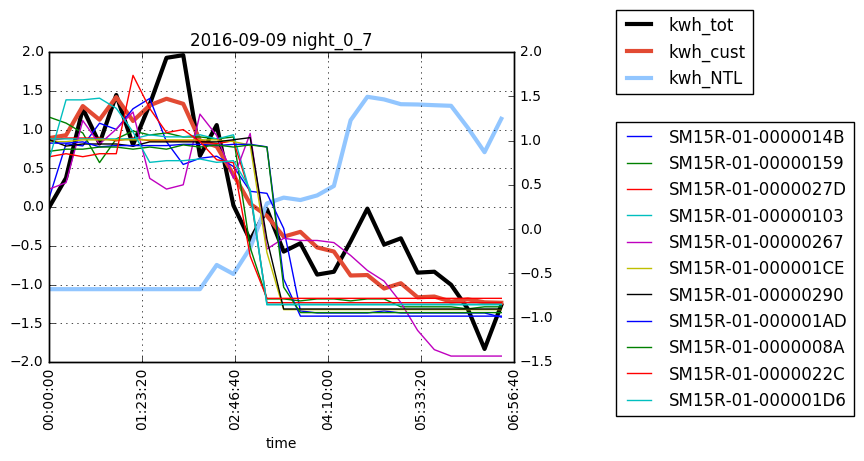

In [171]:
plot_period(bc_consumption,rank_days,day='2016-09-09',pd=0)

The above plot shows the normalized load profiles of the aggregator meter for sub-network "BC" (`kwh_tot`), the sum of meter readings (`kwh_cust`), the estimated non-technical losses (`kwh_NTL`), and the electricity consumption profile of the top-10 suspects in the specified day period, along with the correlation matrix. In this particular example, we can see that as the non-technical losses progressively ramp-up, the totalizer goes down as well as the consumption in the identified meters. This negative correlation capture through K-means, strongly suggests that the homes associated to those meters are likely to be illegally withdrawing power during the specified period.  

## Conclusion

To conclude, in general, both approaches seem to have pros and cons in terms of computing time and accuracy. The unfortunate premise in this problem statement is that we have very limited ground truth about the real theft offenders but it is interesting to note that both algorithms are "catching" the known offenders. Apart from that there are several candidates which are common in the output of both algorithms and some other candidates which are unique. The best way further is to visualize the consumption profile of the common candidates (and then followed by the unique candidates) and compare it to  non technical loss profile to gauge the possibility of theft. Post that the top contenders need to be caught red handed on the ground in Haiti in order to not only send a message to the community, reduce theft, improve revenue collection and help stabilize the microgrid. 

## References

[1] "EarthSpark International." EarthSpark International. N.p., n.d. Web. 11 Dec. 2016.  
(http://www.earthsparkinternational.org/)

[2] "Our Solution." Simple, Powerful Low Cost Smart Metering Systems for Utilities in Developing Countries and Microgrids. N.p., n.d. Web. 11 Dec. 2016.
(http://www.sparkmeter.io/)